#Requirements

In [1]:
!pip install awscli

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.0 MB 29.8 MB/s 
     |████████████████████████████████| 10.3 MB 60.1 MB/s 
     |████████████████████████████████| 548 kB 78.5 MB/s 
     |████████████████████████████████| 79 kB 10.1 MB/s 
     |████████████████████████████████| 662 kB 80.7 MB/s 
     |████████████████████████████████| 140 kB 82.7 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: rsa
    Found existing installation: rsa 4.9
    Uninstalling rsa-4.9:
      Successfully uninstalled rsa-4.9
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 6.0
    Uninstalling PyYAML-6.0:
      Successfully uninstalled PyYAML-6.0
  Attempting uninstall: docutils
    Found existing installation: docutils 0.17.1
    Uninstalling docutils-0.17.1

In [4]:
!pip install transformers
!pip install nvidia-blocks

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 17.6 MB/s 
     |████████████████████████████████| 7.6 MB 63.5 MB/s 
     |████████████████████████████████| 182 kB 77.4 MB/s 
     |████████████████████████████████| 127 kB 76.9 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.26.13
    Uninstalling urllib3-1.26.13:
      Successfully uninstalled urllib3-1.26.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement nvidia-blocks (from versions: none)
ERROR: No matching distribution found for nvidia-blocks


In [5]:
!pip install simplejson
!pip install iopath
!pip install fvcore
!pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 139 kB 27.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 42 kB 1.1 MB/s 
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31547 sha256=194068ff0d85a20565e3be856c771843ddba09327e5e5a7b1b3a9f1400c2a17e
  Stored in directory: /root/.cache/pip/wheels/89/3e/24/0f349c0b2eeb6965903035f3b00dbb5c9bea437b4a2f18d82c
Successfully built iopath
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 3.5 MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221122-py3-none-any.whl size=61484 sha256=af72e142dc39bfd0e7d05f3fecc4ac965c980771b4f1c0a7217a5132b53ac117
  Stored in directory: /root/.cache/pip/wheels/15/6e/e3/602889ca9c5c55020f8d205066445a

#Download data

fMRI

In [2]:
!aws s3 sync --no-sign-request --quiet s3://openneuro.org/ds003688 ds003688-download/

VTN weights

In [8]:
!wget https://researchpublic.blob.core.windows.net/vtn/VTN_VIT_B_KINETICS.pyth

--2022-12-12 21:53:15--  https://researchpublic.blob.core.windows.net/vtn/VTN_VIT_B_KINETICS.pyth
Resolving researchpublic.blob.core.windows.net (researchpublic.blob.core.windows.net)... 20.150.78.68
Connecting to researchpublic.blob.core.windows.net (researchpublic.blob.core.windows.net)|20.150.78.68|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 454099681 (433M) [application/zip]
Saving to: ‘VTN_VIT_B_KINETICS.pyth’

VTN_VIT_B_KINETICS. 100%[===================>] 433.06M  6.16MB/s    in 85s     

2022-12-12 21:54:41 (5.10 MB/s) - ‘VTN_VIT_B_KINETICS.pyth’ saved [454099681/454099681]



#Preprocessing

In [1]:
#preprocessing from other group
import os
import numpy as np
import nibabel as nib
import torch
from multiprocessing import Process, Queue
import pandas as pd


def read_hcp(file_path, global_norm_path, per_voxel_norm_path, count, queue=None):
    img_orig = torch.from_numpy(np.asanyarray(nib.load(file_path).dataobj)).to(dtype=torch.float32)
    background = img_orig == 0
    img_temp = (img_orig - img_orig[~background].mean()) / (img_orig[~background].std())
    img = torch.empty(img_orig.shape)
    img[background] = img_temp.min()
    img[~background] = img_temp[~background]
    img = torch.split(img, 1, 3)
    #if len(os.listdir(global_norm_path)) != 641:
    for i, TR in enumerate(img):
        TR[TR.isnan()] = 0.0
        torch.save(TR.clone(),
                  os.path.join(global_norm_path, 'rfMRI_' + '_TR_' + str(i) + '.pt'))
    #if len(os.listdir(per_voxel_norm_path)) != 641:
    # repeat for per voxel normalization
    img_temp = (img_orig - img_orig.mean(dim=3, keepdims=True)) / (img_orig.std(dim=3, keepdims=True))
    img = torch.empty(img_orig.shape)
    img[background] = img_temp.min()
    img[~background] = img_temp[~background]

    img[img.isnan()] = 0.0
    img[img.isinf()] = 0.0
    img = torch.split(img, 1, 3)
    for i, TR in enumerate(img):
        torch.save(TR.clone(),
                  os.path.join(per_voxel_norm_path, 'rfMRI_' + '_TR_' + str(i) + '.pt'))
    print('finished another subject. count is now {}'.format(count))

def main():
  subjects_dir = 'ds003688-download/'
  subjects = pd.read_csv(subjects_dir + 'participants.tsv', sep='\t')
  subjects_fmri = subjects[subjects['fMRI'] == 'yes']
  queue = Queue()
  count = 0
  for subj_id in subjects_fmri['participant_id']:
      if len(os.listdir(f'/content/ds003688-download/fMRI_to_tensors/{subj_id}/glob_norm')) == 641:
        if len(os.listdir(f'/content/ds003688-download/fMRI_to_tensors/{subj_id}/vox_norm')) == 641:
          continue

      fmri_path = os.path.join(subjects_dir, subj_id, 'ses-mri3t', 'func', f'{subj_id}_ses-mri3t_task-film_run-1_bold.nii.gz')
      if not os.path.exists(fmri_path):
          continue
      glob_norm_path = os.path.join(subjects_dir, 'fMRI_to_tensors', subj_id, 'glob_norm')
      vox_norm_path = os.path.join(subjects_dir, 'fMRI_to_tensors', subj_id, 'vox_norm')
      os.makedirs(glob_norm_path, exist_ok=True)
      os.makedirs(vox_norm_path, exist_ok=True)
      count += 1
      print('start working on subject '+ subj_id)
      
      #read_hcp(fmri_path, glob_norm_path, vox_norm_path)
      p = Process(target=read_hcp, args=(fmri_path, glob_norm_path, vox_norm_path, count, queue))
      p.start()
      if count % 2 == 0:
          p.join()  # this blocks until the process terminates
if __name__ == '__main__':
  main()

#Datasets

In [1]:
import cv2
from torchvision.transforms import ToTensor
cap = cv2.VideoCapture('/content/Film stimulus.mp4')
frames = []
to_tensor = ToTensor()
while(cap.isOpened()):
    # Capture frame-by-frame
    ret, frame = cap.read()
    if ret:
        frame = cv2.resize(frame, (224,224),fx=0,fy=0, interpolation=cv2.INTER_CUBIC)
        frames.append(to_tensor(frame))
    else:
        break
# When everything done, release the video capture object
cap.release()

In [2]:
import os
import torch
from torch.utils.data import Dataset
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import cv2
from torchvision.transforms import ToTensor


class fMRIDataset(Dataset):
    def __init__(self, seq_len: int = 1, total_len=641):
        super().__init__()
        self.data_dir = os.path.join('ds003688-download', 'fMRI_to_tensors')
        self.subjects_data = os.listdir(self.data_dir)
        self.total_len = total_len
        self.seq_len = seq_len
    
    def __getitem__(self, index):
        subj_dir = self.subjects_data[index % len(self.subjects_data)]
        start_idx = index // len(self.subjects_data)

        glob_tensors = torch.stack([torch.load(os.path.join(self.data_dir, subj_dir, 'glob_norm', f'rfMRI__TR_{start_idx + i}.pt'))
            for i in range(self.seq_len)], dim=0)

        vox_tensors = torch.stack([torch.load(os.path.join(self.data_dir, subj_dir, 'vox_norm', f'rfMRI__TR_{start_idx + i}.pt'))
            for i in range(self.seq_len)], dim=0)
        
        glob_tensors = glob_tensors.transpose(0, -1)
        vox_tensors = vox_tensors.transpose(0, -1)
        return torch.cat([glob_tensors, vox_tensors], dim=0)
    
    def __len__(self):
        return len(self.subjects_data) * (self.total_len - self.seq_len + 1)


class fMRIVideoDataset(Dataset):
    def __init__(self, train=True, seq_len=1, video_path='Film stimulus.mp4', skip_frames=1, total_len=641):
        super().__init__()
        assert seq_len % 5 == 0
        self.seq_len = seq_len
        self.total_len = total_len
        self.num_chunks = seq_len // 5
        self.skip_frames = skip_frames

        self.data_dir = os.path.join('ds003688-download', 'fMRI_to_tensors')
        subjects_data = sorted(os.listdir(self.data_dir))
        subjects_data_train, subjects_data_test = train_test_split(subjects_data, test_size=0.3, random_state=0)
        self.start_times = torch.arange(5, self.total_len - 5*self.num_chunks + 1, 5)
        if train:
            self.subjects_data = subjects_data_train
        else:
            self.subjects_data = subjects_data_test

        #self.get_frames(video_path)
        self.frames = frames

    def get_frames(self, video_path):
        cap = cv2.VideoCapture(video_path)
        frames = []
        to_tensor = ToTensor()
        while(cap.isOpened()):
            # Capture frame-by-frame
            ret, frame = cap.read()
            if ret:
                frame = cv2.resize(frame, (224,224),fx=0,fy=0, interpolation=cv2.INTER_CUBIC)
                frames.append(to_tensor(frame))
            else:
                break
        # When everything done, release the video capture object
        cap.release()
        self.frames = frames


    def __getitem__(self, index):
        subj_dir = self.subjects_data[index % len(self.subjects_data)]
        start_idx = self.start_times[index // len(self.subjects_data)]
        start_frame = (start_idx // 5) * 76
        end_frame = start_frame + self.num_chunks * 76
        video = torch.stack(self.frames[start_frame:end_frame:self.skip_frames])
        position_idx = torch.arange(0, end_frame - start_frame, self.skip_frames)

        glob_tensors = torch.stack([torch.load(os.path.join(self.data_dir, subj_dir, 'glob_norm', f'rfMRI__TR_{start_idx + i}.pt'))
            for i in range(self.seq_len)], dim=0)

        vox_tensors = torch.stack([torch.load(os.path.join(self.data_dir, subj_dir, 'vox_norm', f'rfMRI__TR_{start_idx + i}.pt'))
            for i in range(self.seq_len)], dim=0)
        
        glob_tensors = glob_tensors.transpose(0, -1)
        vox_tensors = vox_tensors.transpose(0, -1)
        TFF_input = torch.cat([glob_tensors, vox_tensors], dim=0)

        prev_glob_tensor = torch.load(os.path.join(self.data_dir, subj_dir, 'glob_norm', f'rfMRI__TR_{start_idx - 1}.pt'))
        prev_vox_tensor = torch.load(os.path.join(self.data_dir, subj_dir, 'vox_norm', f'rfMRI__TR_{start_idx - 1}.pt'))
        prev_tensor = torch.stack([prev_glob_tensor, prev_vox_tensor], dim=0)

        return {'fmri_seq':TFF_input, 'fmri_img':prev_tensor, 'video_seq':video, 'pos_idx':position_idx}
    
    def __len__(self):
        return len(self.subjects_data) * len(self.start_times)

#Models

##VTN

In [3]:
#!/usr/bin/env python3
# Copyright (c) Facebook, Inc. and its affiliates. All Rights Reserved.
"""Video models."""

import math
import torch
import torch.nn as nn
from timm.models.vision_transformer import vit_base_patch16_224
from transformers import LongformerModel, LongformerConfig
import torch.nn.functional as F

class VTNLongformerModel(LongformerModel):

    def __init__(self,
                 embed_dim=768,
                 max_position_embeddings=2 * 60 * 60,
                 num_attention_heads=12,
                 num_hidden_layers=3,
                 attention_mode='sliding_chunks',
                 pad_token_id=-1,
                 attention_window=None,
                 intermediate_size=3072,
                 attention_probs_dropout_prob=0.1,
                 hidden_dropout_prob=0.1):

        self.config = LongformerConfig()
        self.config.attention_mode = attention_mode
        self.config.intermediate_size = intermediate_size
        self.config.attention_probs_dropout_prob = attention_probs_dropout_prob
        self.config.hidden_dropout_prob = hidden_dropout_prob
        self.config.attention_dilation = [1, ] * num_hidden_layers
        self.config.attention_window = [256, ] * num_hidden_layers if attention_window is None else attention_window
        self.config.num_hidden_layers = num_hidden_layers
        self.config.num_attention_heads = num_attention_heads
        self.config.pad_token_id = pad_token_id
        self.config.max_position_embeddings = max_position_embeddings
        self.config.hidden_size = embed_dim
        super(VTNLongformerModel, self).__init__(self.config, add_pooling_layer=False)
        self.embeddings.word_embeddings = None  # to avoid distributed error of unused parameters


def pad_to_window_size_local(input_ids: torch.Tensor, attention_mask: torch.Tensor, position_ids: torch.Tensor,
                             one_sided_window_size: int, pad_token_id: int):
    '''A helper function to pad tokens and mask to work with the sliding_chunks implementation of Longformer self-attention.
    Based on _pad_to_window_size from https://github.com/huggingface/transformers:
    https://github.com/huggingface/transformers/blob/71bdc076dd4ba2f3264283d4bc8617755206dccd/src/transformers/models/longformer/modeling_longformer.py#L1516
    Input:
        input_ids = torch.Tensor(bsz x seqlen): ids of wordpieces
        attention_mask = torch.Tensor(bsz x seqlen): attention mask
        one_sided_window_size = int: window size on one side of each token
        pad_token_id = int: tokenizer.pad_token_id
    Returns
        (input_ids, attention_mask) padded to length divisible by 2 * one_sided_window_size
    '''
    w = 2 * one_sided_window_size
    seqlen = input_ids.size(1)
    padding_len = (w - seqlen % w) % w
    input_ids = F.pad(input_ids.permute(0, 2, 1), (0, padding_len), value=pad_token_id).permute(0, 2, 1)
    attention_mask = F.pad(attention_mask, (0, padding_len), value=False)  # no attention on the padding tokens
    position_ids = F.pad(position_ids, (1, padding_len), value=False)  # no attention on the padding tokens
    return input_ids, attention_mask, position_ids


class VTN(nn.Module):
    """
    VTN model builder. It uses ViT-Base as the backbone.

    Daniel Neimark, Omri Bar, Maya Zohar and Dotan Asselmann.
    "Video Transformer Network."
    https://arxiv.org/abs/2102.00719
    """

    def __init__(self, intermediate_vec, vtn_path='VTN_VIT_B_KINETICS.pyth'):
        """
        The `__init__` method of any subclass should also contain these
            arguments.
        Args:
            cfg (CfgNode): model building configs, details are in the
                comments of the config file.
        """
        super(VTN, self).__init__()
        self._construct_network()
        state_dict = torch.load(vtn_path)['model_state']
        state_dict.pop('temporal_encoder.embeddings.position_ids')
        self.load_state_dict(state_dict)
        self.mlp_head[-1] = nn.Linear(768, 2*intermediate_vec)

    def _construct_network(self):
        """
        Builds a VTN model, with a given backbone architecture.
        Args:
            cfg (CfgNode): model building configs, details are in the
                comments of the config file.
        """
        self.backbone = vit_base_patch16_224(pretrained=True,
                                              num_classes=0,
                                              drop_path_rate=0.0,
                                              drop_rate=0.0)
        

        embed_dim = self.backbone.embed_dim
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))

        self.temporal_encoder = VTNLongformerModel(
            embed_dim=embed_dim,
            max_position_embeddings=288,
            num_attention_heads=12,
            num_hidden_layers=3,
            attention_mode='sliding_chunks',
            pad_token_id=-1,
            attention_window=[18, 18, 18],
            intermediate_size=3072,
            attention_probs_dropout_prob=0.1,
            hidden_dropout_prob=0.1)

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(768),
            nn.Linear(768, 768),
            nn.GELU(),
            nn.Dropout(0.5),
            nn.Linear(768, 400)
        )

    def forward(self, x, bboxes=None):

        x, position_ids = x

        # spatial backbone
        B, F, C, H, W = x.shape
        x = x.reshape(B * F, C, H, W)
        x = self.backbone(x)
        x = x.reshape(B, F, -1)

        # temporal encoder (Longformer)
        B, D, E = x.shape
        attention_mask = torch.ones((B, D), dtype=torch.long, device=x.device)
        cls_tokens = self.cls_token.expand(B, -1, -1)  # stole cls_tokens impl from Phil Wang, thanks
        x = torch.cat((cls_tokens, x), dim=1)
        cls_atten = torch.ones(1).expand(B, -1).to(x.device)
        attention_mask = torch.cat((attention_mask, cls_atten), dim=1)
        attention_mask[:, 0] = 2
        x, attention_mask, position_ids = pad_to_window_size_local(
            x,
            attention_mask,
            position_ids,
            self.temporal_encoder.config.attention_window[0],
            self.temporal_encoder.config.pad_token_id)
        token_type_ids = torch.zeros(x.size()[:-1], dtype=torch.long, device=x.device)
        token_type_ids[:, 0] = 1

        # position_ids
        position_ids = position_ids.long()
        mask = attention_mask.ne(0).int()
        max_position_embeddings = self.temporal_encoder.config.max_position_embeddings
        position_ids = position_ids % (max_position_embeddings - 2)
        position_ids[:, 0] = max_position_embeddings - 2
        position_ids[mask == 0] = max_position_embeddings - 1
        #print(position_ids)

        x = self.temporal_encoder(input_ids=None,
                                  attention_mask=attention_mask,
                                  token_type_ids=token_type_ids,
                                  position_ids=position_ids,
                                  inputs_embeds=x,
                                  output_attentions=None,
                                  output_hidden_states=None,
                                  return_dict=None)
        # MLP head
        x = x["last_hidden_state"]
        x = self.mlp_head(x)
        return x


##TFF

In [4]:
import torch
import torch.nn as nn
from collections import OrderedDict

# DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
def tuple_prod(x):
    prod = 1
    for xx in x:
        prod *= xx
    return prod

class GreenBlock(nn.Module):
    def __init__(self, in_channels, out_channels ,drop_rate=0.4):
        """
        green_block(inp, filters, name=None)
        ------------------------------------
        Implementation of the special residual block used in the paper. The block
        consists of two (GroupNorm --> ReLu --> 3x3x3 non-strided Convolution)
        units, with a residual connection from the input `inp` to the output. Used
        internally in the model. Can be used independently as well.
        Note that images must come with dimensions "c, H, W, D"
        Parameters
        ----------
        `inp`: An keras.layers.layer instance, required
            The keras layer just preceding the green block.
        `out_channels`: integer, required
            No. of filters to use in the 3D convolutional block. The output
            layer of this green block will have this many no. of channels.
        Returns
        -------
        `out`: A keras.layers.Layer instance
            The output of the green block. Has no. of channels equal to `filters`.
            The size of the rest of the dimensions remains same as in `inp`.
        """
        super(GreenBlock, self).__init__()
        self.Drop_Rate = drop_rate
        # Define block
        self.block = nn.Sequential(OrderedDict([
            ('group_norm0', nn.GroupNorm(num_channels=in_channels, num_groups=in_channels // 4)),
            #('norm0', nn.BatchNorm3d(num_features=in_channels)),
            ('relu0', nn.LeakyReLU(inplace=True)),
            ('conv0', nn.Conv3d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)),
            ('group_norm1', nn.GroupNorm(num_channels=out_channels, num_groups=in_channels // 4)),
            #('norm1', nn.BatchNorm3d(num_features=out_channels)),
            ('relu1', nn.LeakyReLU(inplace=True)),
            ('conv2', nn.Conv3d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)),
        ]))

    def forward(self, inputs):
        #x_res = self.res(inputs)
        x_res = inputs
        #print('in green block: before')
        x = torch.nn.functional.dropout(self.block(inputs), p=self.Drop_Rate, training=self.training)
        #print('in green block: after')
        #return torch.cat([x, x_res], dim=1)
        return x + x_res



class UpGreenBlock(nn.Sequential):
    def __init__(self, in_features, out_features, shape, Drop_Rate):
        super(UpGreenBlock, self).__init__()

        self.add_module('conv', nn.Conv3d(in_features, out_features, kernel_size=1, stride=1))
        self.add_module('up', nn.Upsample(size=shape))
        self.add_module('green', GreenBlock(out_features, out_features, Drop_Rate))

In [5]:
import os
from abc import ABC, abstractmethod
import torch
from transformers import BertConfig,BertPreTrainedModel, BertModel
from datetime import datetime
import torch.nn as nn
# from nvidia_blocks import *
#from vtn import VTN


class BaseModel(nn.Module, ABC):
    def __init__(self):
        super().__init__()
        self.best_loss = 1000000
        self.best_accuracy = 0

    @abstractmethod
    def forward(self, x):
        pass

    @property
    def device(self):
        return next(self.parameters()).device

    def determine_shapes(self,encoder,dim):
        def get_shape(module,input,output):
            module.input_shape = tuple(input[0].shape[-3:])
            module.output_shape = tuple(output[0].shape[-3:])
        hook1 = encoder.down_block1.register_forward_hook(get_shape)
        hook2 = encoder.down_block3.register_forward_hook(get_shape)
        input_shape = (1,2,) + dim  #batch,norms,H,W,D,time
        x = torch.ones((input_shape))
        with torch.no_grad():
            encoder(x)
            del x
        self.shapes = {'dim_0':encoder.down_block1.input_shape,
                       'dim_1':encoder.down_block1.output_shape,
                       'dim_2':encoder.down_block3.input_shape,
                       'dim_3':encoder.down_block3.output_shape}
        hook1.remove()
        hook2.remove()

    def register_vars(self,**kwargs):
        intermediate_vec = 2640
        if kwargs.get('task') == 'fine_tune':
            self.dropout_rates = {'input': 0, 'green': 0.35,'Up_green': 0,'transformer':0.1}
        else:
            self.dropout_rates = {'input': 0, 'green': 0.2, 'Up_green': 0.2,'transformer':0.1}

        self.BertConfig = BertConfig(hidden_size=intermediate_vec, vocab_size=1,
                                     num_hidden_layers=kwargs.get('transformer_hidden_layers'),
                                     num_attention_heads=16, max_position_embeddings=30,
                                     hidden_dropout_prob=self.dropout_rates['transformer'])

        self.label_num = 1
        self.inChannels = 2
        self.outChannels = 1
        self.model_depth = 4
        self.intermediate_vec = intermediate_vec
        self.use_cuda = kwargs.get('cuda')
        self.shapes = kwargs.get('shapes')


    def load_partial_state_dict(self, state_dict,load_cls_embedding):
        print('loading parameters onto new model...')
        own_state = self.state_dict()
        loaded = {name:False for name in own_state.keys()}
        for name, param in state_dict.items():
            if name not in own_state:
                print('notice: {} is not part of new model and was not loaded.'.format(name))
                continue
            elif 'cls_embedding' in name and not load_cls_embedding:
                continue
            elif 'position' in name and param.shape != own_state[name].shape:
                print('debug line above')
                continue
            param = param.data
            own_state[name].copy_(param)
            loaded[name] = True
        for name,was_loaded in loaded.items():
            if not was_loaded:
                print('notice: named parameter - {} is randomly initialized'.format(name))


    def save_checkpoint(self, directory, title, epoch, optimizer=None,schedule=None):
        # Create directory to save to
        if not os.path.exists(directory):
            os.makedirs(directory)

        # Build checkpoint dict to save.
        ckpt_dict = {
            'model_state_dict':self.state_dict(),
            'optimizer_state_dict':optimizer.state_dict() if optimizer is not None else None,
            'epoch':epoch}

        if schedule is not None:
            ckpt_dict['schedule_state_dict'] = schedule.state_dict()
            ckpt_dict['lr'] = schedule.get_last_lr()[0]
        if hasattr(self,'loaded_model_weights_path'):
            ckpt_dict['loaded_model_weights_path'] = self.loaded_model_weights_path

        # Save the file with specific name
        core_name = title
        name = "{}_last_epoch.pth".format(core_name)
        torch.save(ckpt_dict, os.path.join(directory, name))


class Encoder(BaseModel):
    def __init__(self,**kwargs):
        super(Encoder, self).__init__()
        self.register_vars(**kwargs)
        self.down_block1 = nn.Sequential(OrderedDict([
            ('conv0', nn.Conv3d(self.inChannels, self.model_depth, kernel_size=3, stride=1, padding=1)),
            ('sp_drop0', nn.Dropout3d(self.dropout_rates['input'])),
            ('green0', GreenBlock(self.model_depth, self.model_depth, self.dropout_rates['green'])),
            ('downsize_0', nn.Conv3d(self.model_depth, self.model_depth * 2, kernel_size=3, stride=2, padding=1))]))
        self.down_block2 = nn.Sequential(OrderedDict([
            ('green10', GreenBlock(self.model_depth * 2, self.model_depth * 2, self.dropout_rates['green'])),
            ('green11', GreenBlock(self.model_depth * 2, self.model_depth * 2, self.dropout_rates['green'])),
            ('downsize_1', nn.Conv3d(self.model_depth * 2, self.model_depth * 4, kernel_size=3, stride=2, padding=1))]))
        self.down_block3 = nn.Sequential(OrderedDict([
            ('green20', GreenBlock(self.model_depth * 4, self.model_depth * 4, self.dropout_rates['green'])),
            ('green21', GreenBlock(self.model_depth * 4, self.model_depth * 4, self.dropout_rates['green'])),
            ('downsize_2', nn.Conv3d(self.model_depth * 4, self.model_depth * 8, kernel_size=3, stride=2, padding=1))]))
        self.final_block = nn.Sequential(OrderedDict([
            ('green30', GreenBlock(self.model_depth * 8, self.model_depth * 8, self.dropout_rates['green'])),
            ('green31', GreenBlock(self.model_depth * 8, self.model_depth * 8, self.dropout_rates['green'])),
            ('green32', GreenBlock(self.model_depth * 8, self.model_depth * 8, self.dropout_rates['green'])),
            ('green33', GreenBlock(self.model_depth * 8, self.model_depth * 8, self.dropout_rates['green']))]))

    def forward(self, x):
       # print('before')
        x = self.down_block1(x)
      #  print('after down_block1')
        x = self.down_block2(x)
      #  print('after down_block2')
        x = self.down_block3(x)
       # print('after down_block3')
        x = self.final_block(x)
      #  print('after final block')
        return x


class BottleNeck_in(BaseModel):
    def __init__(self,**kwargs):
        super(BottleNeck_in, self).__init__()
        self.register_vars(**kwargs)
        self.reduce_dimension = nn.Sequential(OrderedDict([
            ('group_normR', nn.GroupNorm(num_channels=self.model_depth * 8, num_groups=8)),
            # ('norm0', nn.BatchNorm3d(model_depth * 8)),
            ('reluR0', nn.LeakyReLU(inplace=True)),
            ('convR0', nn.Conv3d(self.model_depth * 8, self.model_depth // 2, kernel_size=(3, 3, 3), stride=1, padding=1)),
        ]))
        flat_factor = tuple_prod(self.shapes['dim_3'])
        self.flatten = nn.Flatten()
        if (flat_factor * self.model_depth // 2) == self.intermediate_vec:
            self.into_bert = nn.Identity()
            print('flattened vec identical to intermediate vector...\ndroppping fully conneceted bottleneck...')
        else:
            self.into_bert = nn.Linear(in_features=(self.model_depth // 2) * flat_factor, out_features=self.intermediate_vec)

    def forward(self, inputs):
        x = self.reduce_dimension(inputs)
        x = self.flatten(x)
        x = self.into_bert(x)

        return x


class BottleNeck_out(BaseModel):
    def __init__(self,**kwargs):
        super(BottleNeck_out, self).__init__()
        self.register_vars(**kwargs)
        flat_factor = tuple_prod(self.shapes['dim_3'])
        minicube_shape = (self.model_depth // 2,) + self.shapes['dim_3']
        self.out_of_bert = nn.Linear(in_features=self.intermediate_vec, out_features=(self.model_depth // 2) * flat_factor)
        self.expand_dimension = nn.Sequential(OrderedDict([
            ('unflatten', nn.Unflatten(1, minicube_shape)),
            ('group_normR', nn.GroupNorm(num_channels=self.model_depth // 2, num_groups=2)),
            # ('norm0', nn.BatchNorm3d(model_depth * 8)),
            ('reluR0', nn.LeakyReLU(inplace=True)),
            ('convR0', nn.Conv3d(self.model_depth // 2, self.model_depth * 8, kernel_size=(3, 3, 3), stride=1, padding=1)),
        ]))

    def forward(self, x):
        x = self.out_of_bert(x)
        return self.expand_dimension(x)

class Decoder(BaseModel):
    def __init__(self,**kwargs):
        super(Decoder, self).__init__()
        self.register_vars(**kwargs)
        self.decode_block = nn.Sequential(OrderedDict([
            ('upgreen0', UpGreenBlock(self.model_depth * 8, self.model_depth * 4, self.shapes['dim_2'], self.dropout_rates['Up_green'])),
            ('upgreen1', UpGreenBlock(self.model_depth * 4, self.model_depth * 2, self.shapes['dim_1'], self.dropout_rates['Up_green'])),
            ('upgreen2', UpGreenBlock(self.model_depth * 2, self.model_depth, self.shapes['dim_0'], self.dropout_rates['Up_green'])),
            ('blue_block', nn.Conv3d(self.model_depth, self.model_depth, kernel_size=3, stride=1, padding=1)),
            ('output_block', nn.Conv3d(in_channels=self.model_depth, out_channels=self.outChannels, kernel_size=1, stride=1))
        ]))

    def forward(self, x):
        x = self.decode_block(x)
        return x


class AutoEncoder(BaseModel):
    def __init__(self,dim,**kwargs):
        super(AutoEncoder, self).__init__()
        # ENCODING
        self.task = 'autoencoder_reconstruction'
        self.encoder = Encoder(**kwargs)
        self.determine_shapes(self.encoder,dim)
        kwargs['shapes'] = self.shapes
        # BottleNeck into bert
        self.into_bert = BottleNeck_in(**kwargs)

        # BottleNeck out of bert
        self.from_bert = BottleNeck_out(**kwargs)

        # DECODER
        self.decoder = Decoder(**kwargs)

    def forward(self, x):
        if x.isnan().any():
            print('nans in data!')
        batch_size, Channels_in, W, H, D, T = x.shape
        x = x.permute(0, 5, 1, 2, 3, 4).reshape(batch_size * T, Channels_in, W, H, D)
        encoded  = self.encoder(x)
        encoded = self.into_bert(encoded)
        encoded = self.from_bert(encoded)
        reconstructed_image = self.decoder(encoded)
        _, Channels_out, W, H, D = reconstructed_image.shape
        reconstructed_image = reconstructed_image.reshape(batch_size, T, Channels_out, W, H, D).permute(0, 2, 3, 4, 5, 1)
        return {'reconstructed_fmri_sequence': reconstructed_image}

class Transformer_Block(BertPreTrainedModel, BaseModel):
    def __init__(self,config,**kwargs):
        super(Transformer_Block, self).__init__(config)
        self.register_vars(**kwargs)
        self.cls_pooling = True
        self.bert = BertModel(self.BertConfig, add_pooling_layer=self.cls_pooling)
        self.init_weights()
        self.cls_embedding = nn.Sequential(nn.Linear(self.BertConfig.hidden_size, self.BertConfig.hidden_size), nn.LeakyReLU())
        self.register_buffer('cls_id', torch.ones((kwargs.get('batch_size'), 1, self.BertConfig.hidden_size)) * 0.5,persistent=False)


    def concatenate_cls(self, x):
        cls_token = self.cls_embedding(self.cls_id)
        return torch.cat([cls_token, x], dim=1)


    def forward(self, x ):
        inputs_embeds = self.concatenate_cls(x=x)
        outputs = self.bert(input_ids=None,
                            attention_mask=None,
                            token_type_ids=None,
                            position_ids=None,
                            head_mask=None,
                            inputs_embeds=inputs_embeds,
                            encoder_hidden_states=None,
                            encoder_attention_mask=None,
                            output_attentions=None,
                            output_hidden_states=None,
                            return_dict=self.BertConfig.use_return_dict
                            )

        sequence_output = outputs[0][:, 1:, :]
        pooled_cls = outputs[1]

        return {'sequence': sequence_output, 'cls': pooled_cls}


class Encoder_Transformer_Decoder(BaseModel):
    def __init__(self, dim,**kwargs):
        super(Encoder_Transformer_Decoder, self).__init__()
        self.task = 'transformer_reconstruction'
        self.register_vars(**kwargs)
        # ENCODING
        self.encoder = Encoder(**kwargs)
        self.determine_shapes(self.encoder,dim)
        kwargs['shapes'] = self.shapes
        
        # BottleNeck into bert
        self.into_bert = BottleNeck_in(**kwargs)

        # transformer
        self.transformer = Transformer_Block(self.BertConfig, **kwargs)

        # BottleNeck out of bert
        self.from_bert = BottleNeck_out(**kwargs)

        # DECODER
        self.decoder = Decoder(**kwargs)

    def forward(self, x):
        batch_size, inChannels, W, H, D, T = x.shape
        x = x.permute(0, 5, 1, 2, 3, 4).reshape(batch_size * T, inChannels, W, H, D)
        encoded = self.encoder(x)
        encoded = self.into_bert(encoded)
        encoded = encoded.reshape(batch_size, T, -1)
        transformer_dict = self.transformer(encoded)
        out = transformer_dict['sequence'].reshape(batch_size * T, -1)
        out = self.from_bert(out)
        reconstructed_image = self.decoder(out)
        reconstructed_image = reconstructed_image.reshape(batch_size, T, self.outChannels, W, H, D).permute(0, 2, 3, 4, 5, 1)
        return {'reconstructed_fmri_sequence': reconstructed_image}


class BottleNeck_out_VAE(BaseModel):
    def __init__(self,**kwargs):
        super(BottleNeck_out_VAE, self).__init__()
        self.register_vars(**kwargs)
        self.flat_factor = tuple_prod(self.shapes['dim_3'])
        minicube_shape = (self.model_depth // 2,) + self.shapes['dim_3']
        self.out_of_bert = nn.Linear(in_features=self.intermediate_vec, out_features=(self.model_depth // 2) * self.flat_factor)
        self.out_of_bert_2 = nn.Linear(in_features=self.intermediate_vec, out_features=(self.model_depth // 2) * self.flat_factor)

        self.expand_dimension = nn.Sequential(OrderedDict([
            ('unflatten', nn.Unflatten(1, minicube_shape)),
            ('group_normR', nn.GroupNorm(num_channels=self.model_depth // 2, num_groups=2)),
            # ('norm0', nn.BatchNorm3d(model_depth * 8)),
            ('reluR0', nn.LeakyReLU(inplace=True)),
            ('convR0', nn.Conv3d(self.model_depth // 2, self.model_depth * 8, kernel_size=(3, 3, 3), stride=1, padding=1)),
        ]))

    def prior(self, n):
        # ====
        # return n samples from prior distribution (we use standart normal for prior)
        # ====
        z = torch.distributions.Normal(0., 1.).sample((n, (self.model_depth // 2) * self.flat_factor))
        if self.cuda:
            z = z.cuda()
        return z

    def forward(self, x):
        mean = self.out_of_bert(x)
        log_std = self.out_of_bert_2(x)
        #log_std = torch.zeros(mean.shape).cuda()

        x = self.prior(len(mean)) * torch.exp(log_std) + mean

        return self.expand_dimension(x), mean, log_std

class Encoder_Transformer_Decoder_VAE(BaseModel):
    def __init__(self, dim,**kwargs):
        super(Encoder_Transformer_Decoder_VAE, self).__init__()
        self.task = 'vae_reconstruction'
        self.register_vars(**kwargs)
        # ENCODING
        self.encoder = Encoder(**kwargs)
        self.determine_shapes(self.encoder,dim)
        kwargs['shapes'] = self.shapes
        
        # BottleNeck into bert
        self.into_bert = BottleNeck_in(**kwargs)

        # transformer
        self.transformer = Transformer_Block(self.BertConfig, **kwargs)

        # BottleNeck out of bert
        self.from_bert = BottleNeck_out_VAE(**kwargs)

        # DECODER
        self.decoder = Decoder(**kwargs)

    def forward(self, x):
        batch_size, inChannels, W, H, D, T = x.shape
        x = x.permute(0, 5, 1, 2, 3, 4).reshape(batch_size * T, inChannels, W, H, D)
        encoded = self.encoder(x)
        encoded = self.into_bert(encoded)
        encoded = encoded.reshape(batch_size, T, -1)
        transformer_dict = self.transformer(encoded)
        out = transformer_dict['sequence'].reshape(batch_size * T, -1)

        out, mean, log_std = self.from_bert(out)

        reconstructed_image = self.decoder(out)
        reconstructed_image = reconstructed_image.reshape(batch_size, T, self.outChannels, W, H, D).permute(0, 2, 3, 4, 5, 1)
        return {'reconstructed_fmri_sequence': reconstructed_image, 'mean_1':mean, 'log_std_1':log_std}

class VAE_with_VTN(BaseModel):
    def __init__(self, dim,**kwargs):
        super(VAE_with_VTN, self).__init__()
        self.task = 'vae_reconstruction'
        self.register_vars(**kwargs)
        self.vtn_path = kwargs.get('vtn_path')
        # ENCODING
        self.encoder = Encoder(**kwargs)
        self.determine_shapes(self.encoder,dim)
        kwargs['shapes'] = self.shapes
        
        # BottleNeck into bert
        self.into_bert = BottleNeck_in(**kwargs)

        # transformer
        self.transformer = Transformer_Block(self.BertConfig, **kwargs)

        # BottleNeck out of bert
        self.from_bert = BottleNeck_out_VAE(**kwargs)

        # DECODER
        self.decoder = Decoder(**kwargs)

        #VTN
        self.vtn = VTN((self.from_bert.model_depth // 2) * self.from_bert.flat_factor, vtn_path=self.vtn_path)

    def forward(self, input_dict):
        x = input_dict['fmri_seq']
        x_0 = input_dict['fmri_img']
        video = input_dict['video_seq']
        pos_idx = input_dict['pos_idx']
        #vae 
        batch_size, inChannels, W, H, D, T = x.shape
        x = x.permute(0, 5, 1, 2, 3, 4).reshape(batch_size * T, inChannels, W, H, D)
        encoded = self.encoder(x)
        encoded = self.into_bert(encoded)
        encoded = encoded.reshape(batch_size, T, -1)
        transformer_dict = self.transformer(encoded)
        out = transformer_dict['sequence'].reshape(batch_size * T, -1)

        out, mean_1, log_std_1 = self.from_bert(out)

        reconstructed_image = self.decoder(out)
        reconstructed_image = reconstructed_image.reshape(batch_size, T, self.outChannels, W, H, D).permute(0, 2, 3, 4, 5, 1)

        #vtn
        #batch_size, inChannels, W, H, D, t = x_0.shape
        assert x_0.shape[-1] == 1
        x_0 = x_0.permute(0, 5, 1, 2, 3, 4).reshape(batch_size, inChannels, W, H, D)
        encoded = self.encoder(x_0)
        encoded = self.into_bert(encoded)
        encoded = encoded.reshape(batch_size, 1, -1)
        transformer_dict = self.transformer(encoded)
        out = transformer_dict['sequence'].reshape(batch_size, -1)
        _, mean_0, log_std_0 = self.from_bert(out)

        mean_2, log_std_2 = self.vtn((video, pos_idx)).chunk(2, dim=-1)

        mean_2 = mean_2[:, 1:pos_idx.shape[-1]+1:4].reshape(batch_size * T, -1)
        log_std_2 = log_std_2[:, 1:pos_idx.shape[-1]+1:4].reshape(batch_size * T, -1)
        #print(mean_2.shape)
        #print(mean_0.shape)
        mean_2 = mean_2 + mean_0
        log_std_2 = torch.logaddexp(log_std_0, log_std_2)

        return {'reconstructed_fmri_sequence': reconstructed_image, 'mean_1':mean_1, 'log_std_1':log_std_1,
                'mean_2':mean_2, 'log_std_2':log_std_2}

class Simple_VAE_with_VTN(BaseModel):
    def __init__(self, dim,**kwargs):
        super(Simple_VAE_with_VTN, self).__init__()
        self.task = 'vae_reconstruction'
        self.register_vars(**kwargs)
        self.vtn_path = kwargs.get('vtn_path')
        # ENCODING
        self.encoder = Encoder(**kwargs)
        self.determine_shapes(self.encoder,dim)
        kwargs['shapes'] = self.shapes
        
        # BottleNeck into bert
        self.into_bert = BottleNeck_in(**kwargs)

        # BottleNeck out of bert
        self.from_bert = BottleNeck_out_VAE(**kwargs)

        # DECODER
        self.decoder = Decoder(**kwargs)

        #VTN
        self.vtn = VTN((self.from_bert.model_depth // 2) * self.from_bert.flat_factor, vtn_path=self.vtn_path)

    def forward(self, input_dict):
        x = input_dict['fmri_seq']
        x_0 = input_dict['fmri_img']
        video = input_dict['video_seq']
        pos_idx = input_dict['pos_idx']
        #vae 
        batch_size, inChannels, W, H, D, T = x.shape
        x = x.permute(0, 5, 1, 2, 3, 4).reshape(batch_size * T, inChannels, W, H, D)
        encoded = self.encoder(x)
        encoded = self.into_bert(encoded)
        out, mean_1, log_std_1 = self.from_bert(out)

        reconstructed_image = self.decoder(out)
        reconstructed_image = reconstructed_image.reshape(batch_size, T, self.outChannels, W, H, D).permute(0, 2, 3, 4, 5, 1)

        #vtn
        #batch_size, inChannels, W, H, D, t = x_0.shape
        assert x_0.shape[-1] == 1
        x_0 = x_0.permute(0, 5, 1, 2, 3, 4).reshape(batch_size, inChannels, W, H, D)
        encoded = self.encoder(x_0)
        encoded = self.into_bert(encoded)
        _, mean_0, log_std_0 = self.from_bert(out)

        mean_2, log_std_2 = self.vtn((video, pos_idx)).chunk(2, dim=-1)

        mean_2 = mean_2[:, 1:pos_idx.shape[-1]+1:4].reshape(batch_size * T, -1)
        log_std_2 = log_std_2[:, 1:pos_idx.shape[-1]+1:4].reshape(batch_size * T, -1)
        #print(mean_2.shape)
        #print(mean_0.shape)
        mean_2 = mean_2 + mean_0
        log_std_2 = torch.logaddexp(log_std_0, log_std_2)

        return {'reconstructed_fmri_sequence': reconstructed_image, 'mean_1':mean_1, 'log_std_1':log_std_1,
                'mean_2':mean_2, 'log_std_2':log_std_2}

#Training

In [6]:
from torch.optim.lr_scheduler import StepLR

class LrHandler():
    def __init__(self,**kwargs):
        self.final_lr = 1e-5
        self.base_lr = kwargs.get('lr_init')
        self.gamma = kwargs.get('lr_gamma')
        self.step_size = kwargs.get('lr_step')


    def set_lr(self,dict_lr):
        if self.base_lr is None:
            self.base_lr = dict_lr

    def set_schedule(self,optimizer):
        self.schedule = StepLR(optimizer, step_size=self.step_size, gamma=self.gamma)

    def schedule_check_and_update(self):
        if self.schedule.get_last_lr()[0] > self.final_lr:
            self.schedule.step()

In [7]:
import torch
import torch.nn as nn
from torchvision import models

def get_intense_voxels(yy,shape):
    y = yy.clone()
    low_quantile, high_quantile, = (0.9,0.99)
    voxels = torch.empty(shape)
    for batch in range(y.shape[0]):
        for TR in range(y.shape[-1]):
            yy = y[batch, :, :, :, TR]
            background = yy[0, 0, 0]
            yy[yy <= background] = 0
            yy = abs(yy)
            voxels[batch, :, :, :, :, TR] = (yy > torch.quantile(yy[yy > 0], low_quantile)).unsqueeze(0)
    return voxels.view(shape)>0

class Vgg16(nn.Module):
    def __init__(self):
        super(Vgg16, self).__init__()
        features = models.vgg16(pretrained=True).features
        self.to_relu_1_2 = nn.Sequential()
        self.to_relu_2_2 = nn.Sequential()
        self.to_relu_3_3 = nn.Sequential()
        for x in range(4):
            self.to_relu_1_2.add_module(str(x), features[x])
        for x in range(4, 9):
            self.to_relu_2_2.add_module(str(x), features[x])
        for x in range(9, 16):
            self.to_relu_3_3.add_module(str(x), features[x])

        # don't need the gradients, just want the features
        for param in self.parameters():
            param.requires_grad = False

    def forward(self, x):
        h = self.to_relu_1_2(x)
        h_relu_1_2 = h
        h = self.to_relu_2_2(h)
        h_relu_2_2 = h
        h = self.to_relu_3_3(h)
        #h_relu_3_3 = h
        out = (h_relu_1_2, h_relu_2_2)
        return out

class Percept_Loss(nn.Module):
    def __init__(self, memory_constraint: float, use_cuda=False):
        super(Percept_Loss, self).__init__()
        print('notice: changed layers in perceptual back to old version')
        self.memory_constraint = memory_constraint
        self.vgg = Vgg16()
        if use_cuda:
            self.vgg.cuda()

        self.loss = nn.MSELoss()

    def forward(self, input, target):
        assert input.shape == target.shape, 'input and target should have identical dimension'
        assert len(input.shape) == 6
        batch, channel, width, height, depth, T = input.shape
        num_slices = batch * T * depth
        represent = torch.randperm(num_slices)[:int(num_slices * self.memory_constraint)]
        input = input.permute(0, 5, 1, 4, 2, 3).reshape(num_slices, 1, width, height)
        target = target.permute(0, 5, 1, 4, 2, 3).reshape(num_slices, 1, width, height)
        input = input[represent, :, :, :].repeat(1,3,1,1)
        target = target[represent, :, :, :].repeat(1,3,1,1)

        input = self.vgg(input)
        target = self.vgg(target)
        loss = 0
        for i,j in zip(input,target):
            loss += self.loss(i,j)
        return loss

In [8]:
#from loss_writer import Writer
#from learning_rate import LrHandler
#from data_preprocess_and_load.datasets import fMRIVideoDataset, fMRIDataset
from torch.utils.data import DataLoader
import torch
import warnings
from tqdm import tqdm
#from model import Encoder_Transformer_Decoder,Encoder_Transformer_finetune,AutoEncoder
#from losses import get_intense_voxels

class Trainer():
    """
    main class to handle training, validation and testing.
    note: the order of commands in the constructor is necessary
    """
    def __init__(self,**kwargs):
        self.register_args(**kwargs)
        self.lr_handler = LrHandler(**kwargs)
        if 'video' in self.task.lower():
          dataset = fMRIVideoDataset(train=True, seq_len=self.seq_len, 
                                     video_path=self.video_path, skip_frames=self.skip_frames)
        else:
          dataset = fMRIDataset(seq_len=self.seq_len)
        self.train_loader = DataLoader(dataset=dataset, batch_size=self.batch_size, shuffle=True, drop_last=True)
        self.create_model()
        self.initialize_weights(load_cls_embedding=False)
        self.create_optimizer()
        self.lr_handler.set_schedule(self.optimizer)

        if 'vae' in self.task.lower():
            self.use_KL = True
        else:
            self.use_KL = False
            self.KL_factor = 0

        self.losses = {'intensity':
                           {'is_active':True,'factor':self.intensity_factor},
                       'perceptual':
                           {'is_active':True, 'factor':self.perceptual_factor},
                       'reconstruction':
                           {'is_active':True,'factor':self.reconstruction_factor},
                       'KL':
                           {'is_active':self.use_KL,'factor':self.KL_factor}}
        self.reconstruction_loss_func = nn.L1Loss()
        self.perceptual_loss_func = Percept_Loss(self.memory_constraint, self.cuda)
        self.intensity_loss_func = nn.L1Loss() #(thresholds=[0.9, 0.99]

    def initialize_weights(self,load_cls_embedding):
        if self.loaded_model_weights_path is not None:
            state_dict = torch.load(self.loaded_model_weights_path)
            self.lr_handler.set_lr(state_dict['lr'])
            self.model.load_partial_state_dict(state_dict['model_state_dict'], load_cls_embedding)

    def save_model(self):
        epoch = self.nEpochs
        self.model.save_checkpoint(self.directory, self.title, epoch,
                                      optimizer=self.optimizer,schedule=self.lr_handler.schedule)


    def create_optimizer(self):
        lr = self.lr_handler.base_lr
        params = self.model.parameters()
        weight_decay = self.kwargs.get('weight_decay')
        self.optimizer = torch.optim.Adam(params, lr=lr, weight_decay=weight_decay)

    def create_model(self):
        dim = (40, 64, 64)
        if self.task.lower() == 'vae_reconstruction':
            self.model = Encoder_Transformer_Decoder_VAE(dim,**self.kwargs)
        elif self.task.lower() == 'video_vae':
            self.model = VAE_with_VTN(dim,**self.kwargs)
        elif self.task.lower() == 'simple_video_vae':
            self.model = Simple_VAE_with_VTN(dim,**self.kwargs)
        elif self.task.lower() == 'autoencoder_reconstruction':
            self.model = AutoEncoder(dim,**self.kwargs)
        elif self.task.lower() == 'transformer_reconstruction':
            self.model = Encoder_Transformer_Decoder(dim,**self.kwargs)
        if self.cuda:
            self.model = self.model.cuda()

    def training(self):
        loss_history = {name:[] for name, current_loss_dict in self.losses.items() if current_loss_dict['is_active']}
        for epoch in range(self.nEpochs):
            epoch_losses = self.train_epoch(epoch)
            for name in loss_history.keys():
              loss_history[name] += epoch_losses[name]
              print(name + f' loss {epoch_losses[name][-1]}')

            print('______epoch summary {}/{}_____\n'.format(epoch+1,self.nEpochs))
            #print(f'intensity loss {int_loss[-1]}, perceptual loss {perc_loss[-1]}, reconstruction loss {rec_loss[-1]}')
        return loss_history


    def train_epoch(self,epoch):
        self.train()
        epoch_losses = {name:[] for name, current_loss_dict in self.losses.items() if current_loss_dict['is_active']}

        for batch_idx, input_dict in enumerate(tqdm(self.train_loader)):
           # self.writer.total_train_steps += 1
            self.optimizer.zero_grad()
            loss_dict, loss = self.forward_pass(input_dict)

            for name in epoch_losses.keys():
                epoch_losses[name].append(loss_dict[name])

            torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
            loss.backward()
            self.optimizer.step()
            self.lr_handler.schedule_check_and_update()
           # if batch_idx % 20 == 0:
           #     print(loss_dict)

        return epoch_losses

    def train(self):
        self.mode = 'train'
        self.model = self.model.train()

    def forward_pass(self,input_dict):
        #input_dict = {k:(v.cuda() if self.cuda else v) for k,v in input_dict.items()}
        if self.cuda:
            if isinstance(input_dict, dict):
                input_dict = {k:(v.cuda() if self.cuda else v) for k,v in input_dict.items()}
            else:
                input_dict = input_dict.cuda()

        output_dict = self.model(input_dict)
        loss_dict, loss = self.aggregate_losses(input_dict, output_dict)
        #if self.task == 'fine_tune':
        #    self.compute_accuracy(input_dict, output_dict)
        return loss_dict, loss


    def aggregate_losses(self,input_dict,output_dict):
        final_loss_dict = {}
        final_loss_value = 0
        if isinstance(input_dict, dict):
          input = input_dict['fmri_seq']
        else:
          input = input_dict
        for loss_name, current_loss_dict in self.losses.items():
            if current_loss_dict['is_active']:
                loss_func = getattr(self, 'compute_' + loss_name)
                current_loss_value = loss_func(input, output_dict)
                if current_loss_value.isnan().sum() > 0:
                    warnings.warn('found nans in computation')
                    print('at {} loss'.format(loss_name))
                lamda = current_loss_dict['factor']
                factored_loss = current_loss_value * lamda
                final_loss_dict[loss_name] = factored_loss.item()
                final_loss_value += factored_loss

        final_loss_dict['total'] = final_loss_value.item()
        return final_loss_dict, final_loss_value

    def compute_KL(self,input_dict,output_dict):
        """
            This function returns the value of KL(p1 || p2),
            where p1 = Normal(mean_1, exp(log_std_1)**2), p2 is standard normal distribution.
            Note that we consider the case of diagonal covariance matrix.
        """
        mean_1 = output_dict['mean_1']
        log_std_1 = output_dict['log_std_1']

        if 'mean_2' in output_dict.keys():
          mean_2 = output_dict['mean_2']
          log_std_2 = output_dict['log_std_2']
        else:
          mean_2 = torch.zeros_like(mean_1)
          log_std_2 = torch.zeros_like(log_std_1)
 
        var_1 = torch.exp(log_std_1) ** 2
        var_2 = torch.exp(log_std_2) ** 2

        KL = 2*(log_std_2 - log_std_1) - mean_1.shape[-1] + (mean_1 - mean_2)**2 / var_2 + var_1 / var_2
        return torch.mean(KL / 2)

    def compute_reconstruction(self,input_dict,output_dict):
        fmri_sequence = input_dict[:,0].unsqueeze(1)
        reconstruction_loss = self.reconstruction_loss_func(output_dict['reconstructed_fmri_sequence'],fmri_sequence)
        return reconstruction_loss

    def compute_intensity(self,input_dict,output_dict):
        per_voxel = input_dict[:,1,:,:,:,:]
        voxels = get_intense_voxels(per_voxel, output_dict['reconstructed_fmri_sequence'].shape)
        output_intense = output_dict['reconstructed_fmri_sequence'][voxels]
        truth_intense = input_dict[:,0][voxels.squeeze(1)]
        intensity_loss = self.intensity_loss_func(output_intense.squeeze(), truth_intense)
        return intensity_loss

    def compute_perceptual(self,input_dict,output_dict):
        fmri_sequence = input_dict[:,0].unsqueeze(1)
        perceptual_loss = self.perceptual_loss_func(output_dict['reconstructed_fmri_sequence'],fmri_sequence)
        return perceptual_loss

    def register_args(self,**kwargs):
        for name,value in kwargs.items():
            setattr(self,name,value)
        self.kwargs = kwargs


In [ ]:
args = {'lr_init':1e-3, 'lr_gamma':0.97, 'lr_step':1000, 'seq_len':5,
        'weight_decay':1e-7, 'task':'transformer_reconstruction', 'cuda':True, 
        'transformer_hidden_layers':2, 'batch_size':8,
        'reconstruction_factor':1, 'perceptual_factor':1, 'intensity_factor':1,
        'title':'Transformer', 'directory':'/content/drive/MyDrive/TFF_weights',
        'nEpochs':1, 'memory_constraint':0.1, 'loaded_model_weights_path':'/content/drive/MyDrive/TFF_weights/AutoEncoder_last_epoch.pth'}
trainer = Trainer(**args)

In [ ]:
history_losses = trainer.training()

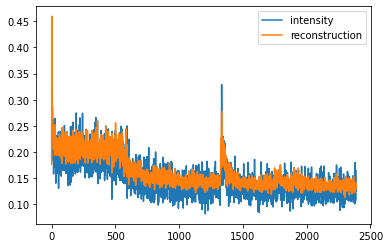

In [11]:
import matplotlib.pyplot as plt
plt.plot(history_losses['intensity'], label='intensity')
plt.plot(history_losses['reconstruction'], label='reconstruction')
plt.legend()
plt.show()

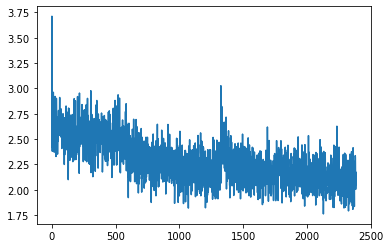

In [12]:
plt.plot(history_losses['perceptual'], label='perceptual')
plt.show()

In [ ]:
args = {'lr_init':1e-3, 'lr_gamma':0.97, 'lr_step':1000, 'seq_len':5,
        'weight_decay':1e-7, 'task':'video_vae', 'cuda':True, 
        'transformer_hidden_layers':2, 'batch_size':1,
        'reconstruction_factor':1, 'perceptual_factor':1, 'intensity_factor':1,
        'KL_factor':1e-3, 'video_path':'Film stimulus.mp4', 'skip_frames':4, 'vtn_path':'VTN_VIT_B_KINETICS.pyth',
        'nEpochs':1, 'memory_constraint':0.1, 'loaded_model_weights_path':'/content/drive/MyDrive/AutoEncoder_last_epoch.pth'}
trainer = Trainer(**args)

In [9]:
args = {'lr_init':1e-3, 'lr_gamma':0.97, 'lr_step':1000, 'seq_len':5,
        'weight_decay':1e-7, 'task':'video_vae', 'cuda':True, 
        'transformer_hidden_layers':2, 'batch_size':1,
        'reconstruction_factor':1, 'perceptual_factor':1, 'intensity_factor':1,
        'KL_factor':1e-3, 'video_path':'Film stimulus.mp4', 'skip_frames':4, 'vtn_path':'VTN_VIT_B_KINETICS.pyth',
        'nEpochs':1, 'memory_constraint':0.1, 'loaded_model_weights_path':'/content/drive/MyDrive/Transformer_last_epoch.pth'}
trainer = Trainer(**args)

loading parameters onto new model...
notice: named parameter - transformer.cls_embedding.0.weight is randomly initialized
notice: named parameter - transformer.cls_embedding.0.bias is randomly initialized
notice: named parameter - from_bert.out_of_bert_2.weight is randomly initialized
notice: named parameter - from_bert.out_of_bert_2.bias is randomly initialized
notice: named parameter - vtn.cls_token is randomly initialized
notice: named parameter - vtn.backbone.cls_token is randomly initialized
notice: named parameter - vtn.backbone.pos_embed is randomly initialized
notice: named parameter - vtn.backbone.patch_embed.proj.weight is randomly initialized
notice: named parameter - vtn.backbone.patch_embed.proj.bias is randomly initialized
notice: named parameter - vtn.backbone.blocks.0.norm1.weight is randomly initialized
notice: named parameter - vtn.backbone.blocks.0.norm1.bias is randomly initialized
notice: named parameter - vtn.backbone.blocks.0.attn.qkv.weight is randomly initializ

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [27]:
history_losses = trainer.training()

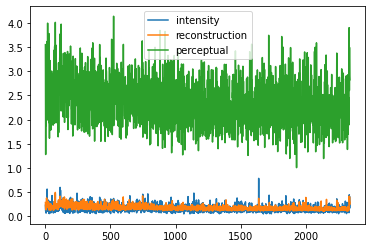

In [14]:
import matplotlib.pyplot as plt
plt.plot(history_losses['intensity'][:2340], label='intensity')
plt.plot(history_losses['reconstruction'][:2340], label='reconstruction')
plt.plot(history_losses['perceptual'][:2340], label='perceptual')
plt.legend()
plt.show()

In [24]:
loss = np.array(history_losses['KL']) + np.array(history_losses['reconstruction'])+ np.array(history_losses['intensity']) + np.array(history_losses['perceptual'])

(0.0, 5.0)

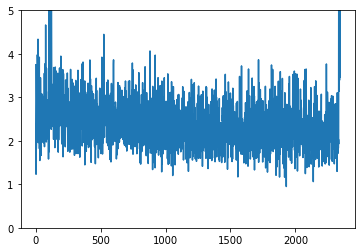

In [26]:
plt.plot(loss)
plt.ylim([0, 5])